# Selecting Optimal Fantasy Premier League Squad with Linear Programming

### 1) Import packages

In [1]:
# import modules
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import *

### 2) Download latest statistics

In [2]:
# set path
filename = 'C:\\Users\\Roland\\Downloads\\fplAnalytics-playerStautsData.csv'

# delete file if exists
try:
    os.remove(filename)
except OSError:
    pass

# download most recent version
url = 'https://0e0c55ie39.execute-api.eu-central-1.amazonaws.com/default/fplAnalytics-DownloadPlayerStatusData'
r = requests.get(url,allow_redirects=True)
open(filename, 'wb').write(r.content)

# input data to dataframe
fpl_df = pd.read_csv(filename, sep = ',', header = 0)

### 3) Exploratory Data Analysis

In [3]:
# add roi and points per game roi index
fpl_df['roi'] = fpl_df['total_points'] / fpl_df['cost']
fpl_df['ppg_roi_index'] = fpl_df['points_per_game'] / fpl_df['cost']*100

# filter out players below x mins playtime and players not available
fpl_df2 = fpl_df[(fpl_df['minutes'] > 300) & (fpl_df['status'].isin(['Available', 'Doubtful']))]

# top 10 players by roi
roitop_df = fpl_df2.nlargest(10, 'roi')

#bottom 10 players by roi
roibottom_df = fpl_df2.nsmallest(10, 'roi')

# top 10 players by ppg roi index
ppgroitop_df = fpl_df2.nlargest(10, 'ppg_roi_index')

#bottom 10 players by ppg roi index
ppgroibottom_df = fpl_df2.nsmallest(10, 'ppg_roi_index')

Text(0.5, 1.0, 'Player points vs. cost')

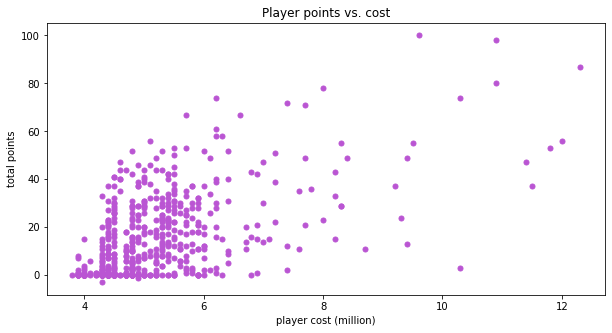

In [4]:
plt.figure(figsize = (10,5))
plt.scatter(fpl_df['cost'], fpl_df['total_points'], 25, color='mediumorchid')
plt.xlabel('player cost (million)')
plt.ylabel('total points')
plt.title('Player points vs. cost')

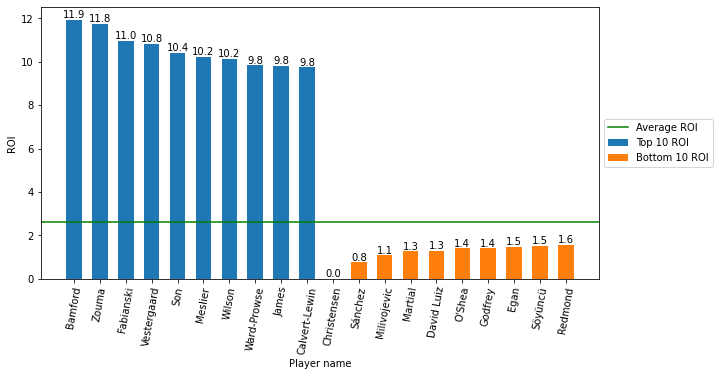

In [5]:
avg_roi = fpl_df['roi'].mean()
plt.figure(figsize=(10,5))
bar1 = plt.bar(roitop_df['name'], roitop_df['roi'], width = 0.6, label = 'Top 10 ROI')
bar2 = plt.bar(roibottom_df['name'], roibottom_df['roi'], width = 0.6, label = 'Bottom 10 ROI')
plt.xticks(rotation = 80)
plt.xlabel('Player name')
plt.ylabel('ROI')
plt.axhline(avg_roi, color='green', label = 'Average ROI')
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % float(height), ha='center', va='bottom')

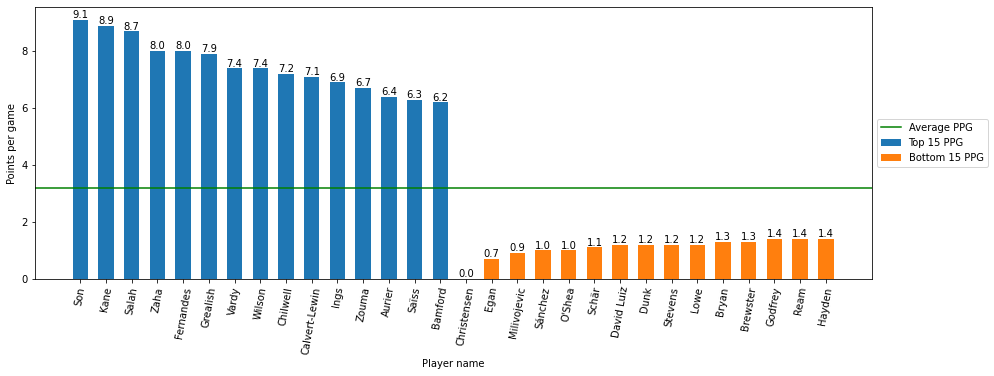

In [6]:
topppg_df = fpl_df2.nlargest(15, 'points_per_game')
bottomppg_df = fpl_df2.nsmallest(15, 'points_per_game')

avg_ppg = fpl_df2['points_per_game'].mean()
plt.figure(figsize=(15,5))
bar1 = plt.bar(topppg_df['name'], topppg_df['points_per_game'], width = 0.6, label = 'Top 15 PPG')
bar2 = plt.bar(bottomppg_df['name'], bottomppg_df['points_per_game'], width = 0.6, label = 'Bottom 15 PPG')
plt.xticks(rotation = 80)
plt.xlabel('Player name')
plt.ylabel('Points per game')
plt.axhline(avg_ppg, color='green', label = 'Average PPG')
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % float(height), ha='center', va='bottom')

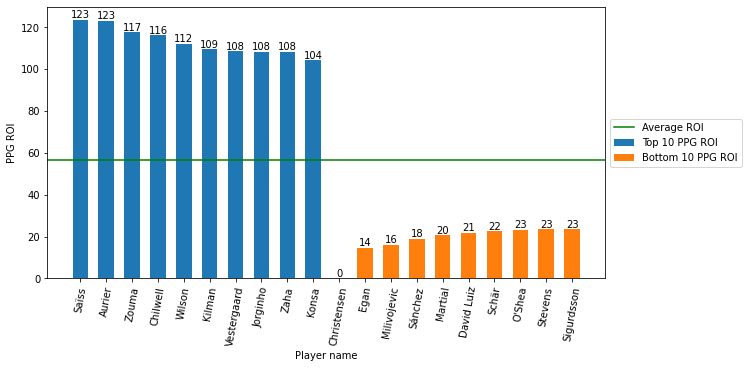

In [7]:
avg_ppgroi = fpl_df2['ppg_roi_index'].mean()
plt.figure(figsize=(10,5))
bar1 = plt.bar(ppgroitop_df['name'], ppgroitop_df['ppg_roi_index'], width = 0.6, label = 'Top 10 PPG ROI')
bar2 = plt.bar(ppgroibottom_df['name'], ppgroibottom_df['ppg_roi_index'], width = 0.6, label = 'Bottom 10 PPG ROI')
plt.xticks(rotation = 80)
plt.xlabel('Player name')
plt.ylabel('PPG ROI')
plt.axhline(avg_ppgroi, color='green', label = 'Average ROI')
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

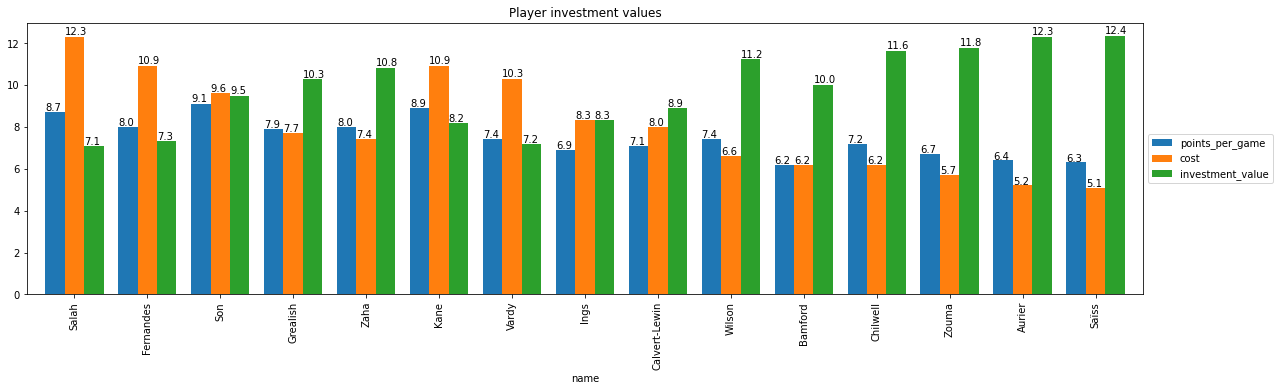

In [8]:
topppg_df['investment_value'] =  topppg_df['points_per_game'] / topppg_df['cost'] * 10
df_srtd = topppg_df.sort_values(by = ['position', 'cost'], ascending = False)
ax = df_srtd.plot(x = 'name', y = ['points_per_game','cost', 'investment_value'], title = 'Player investment values', kind='bar', width=0.8, figsize = (20,5))
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=1), (p.get_x(), p.get_height() * 1.01))

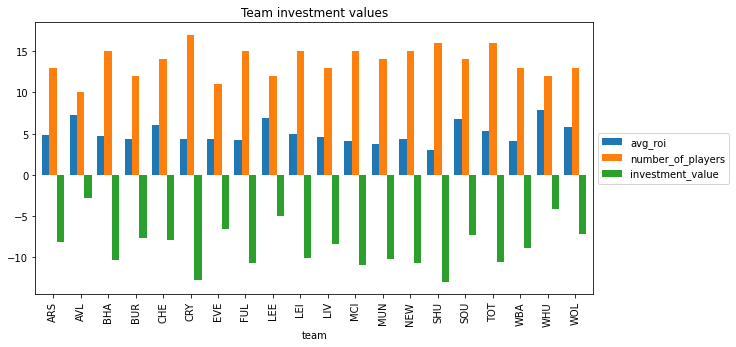

In [9]:
# average roi vs. number of players
df = fpl_df2.groupby('team').agg({'roi': 'mean', 'name': 'count'})
df.columns = ['avg_roi', 'number_of_players']
df['investment_value'] = df['avg_roi'] - df['number_of_players']
ax = df.plot(title = 'Team investment values', kind='bar', width=0.8, figsize = (10,5))
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))


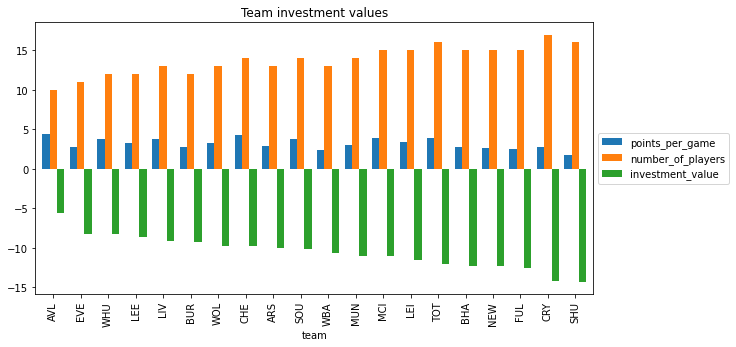

In [12]:
# average ppg roi vs. number of players
df = fpl_df2.groupby('team').agg({'points_per_game': 'mean', 'name': 'count'})
df.columns = ['points_per_game', 'number_of_players']
df['investment_value'] =  df['points_per_game'] - df['number_of_players']
df_srtd = df.sort_values(by = ['investment_value'], ascending = False)
ax = df_srtd.plot(title = 'Team investment values', kind='bar', width=0.8, figsize = (10,5))
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))

### 4) Build Dream Team

In [13]:
def getdreamteam(total_points, costs, positions, teams, statuses, playtime):
    num_players = len(total_points)
    
    model = pulp.LpProblem('Maximize points', pulp.LpMaximize)
    decisions = [
        pulp.LpVariable('x' + str(i), cat='Binary') for i in range(num_players)
    ]

    # objective function:
    model += sum(decisions[i] * total_points[i] for i in range(num_players)), 'Objective'

    # cost constraint
    model += sum(decisions[i] * costs[i] for i in range(num_players)) <= 100  # total cost
    model += sum(decisions) == 15  # total team size

    # team constraint
    for team in np.unique(teams):
        model += sum(decisions[i] for i in range(num_players) if teams[i] == team) <= 3  # max 3 players
        
    # position constraints
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 'GKP') == 2 # 2 goalkeepers
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 'DEF') == 5 # 5 defenders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 'MID') == 5 # 5 midfielders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 'FWD') == 3 # 3 forwards
    
    # injury constraint
    for status in np.unique(statuses):
        model += sum(decisions[i] for i in range(num_players) if statuses[i] in ["Available", "Doubtful"]) == 15  # 15 healthy players
    
    #playtime constraint
    model += sum(decisions[i] for i in range(num_players) if playtime[i] >= 300) == 15 # 15 players who played at least 500 mins
    
    model.solve()
    
    print('Status:', LpStatus[model.status])
    print('Total points:', pulp.value(model.objective))

    return decisions
    

total_points = fpl_df['total_points']
costs = fpl_df['cost']
positions = fpl_df['position']
teams = fpl_df['team']
statuses = fpl_df['status']
playtime = fpl_df['minutes']

pts = fpl_df['total_points']

players = fpl_df['name']
decisions = getdreamteam(total_points.values, costs.values, positions.values, teams.values, statuses.values, playtime.values)
total_cost = 0

print('Total cost:', sum(costs[i] for i in range(1, len(fpl_df)) if decisions[i].value() == 1))

for i in range(1,len(fpl_df)):
    if decisions[i].value() == 1:
        print(players[i], teams[i], positions[i], total_points[i], costs[i], statuses[i])
        total_cost += costs[i]


C:\Users\Roland\Anaconda3\lib\site-packages\pulp\pulp.py:1137: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Status: Optimal
Total points: 996.0
Total cost: 99.99999999999999
Gabriel ARS DEF 46 5.1 Available
Grealish AVL MID 71 7.7 Available
Zouma CHE DEF 67 5.7 Available
James CHE DEF 52 5.3 Available
Chilwell CHE DEF 58 6.2 Available
Zaha CRY MID 72 7.4 Available
Calvert-Lewin EVE FWD 78 8.0 Available
Bamford LEE FWD 74 6.2 Available
Vestergaard SOU DEF 52 4.8 Available
Ward-Prowse SOU MID 61 6.2 Available
Lloris TOT GKP 53 5.5 Available
Kane TOT FWD 98 10.9 Available
Son TOT MID 100 9.6 Available
Fabianski WHU GKP 56 5.1 Available
Bowen WHU MID 58 6.3 Available


### 5) Build Money Team

In [14]:
def getmoneyteam(roi, costs, positions, teams, statuses, playtime):
    num_players = len(total_points)
    
    model = pulp.LpProblem('Maximize ROI', pulp.LpMaximize)
    decisions = [
        pulp.LpVariable('x' + str(i), cat='Binary') for i in range(num_players)
    ]

    # objective function:
    model += sum(decisions[i] * roi[i] for i in range(num_players)), 'Objective'

    # cost constraint
    model += sum(decisions[i] * costs[i] for i in range(num_players)) <= 100  # total cost
    model += sum(decisions) == 15  # total team size

    # team constraint
    for team in np.unique(teams):
        model += sum(decisions[i] for i in range(num_players) if teams[i] == team) <= 3  # max 3 players
        
    # position constraints
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 'GKP') == 2 # 2 goalkeepers
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 'DEF') <= 5 # 5 defenders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 'MID') <= 5 # 5 midfielders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 'FWD') <= 3 # 3 forwards
    
    # injury constraint
    for status in np.unique(statuses):
        model += sum(decisions[i] for i in range(num_players) if statuses[i] in ["Available", "Doubtful"]) == 15  # 15 healthy players
    
    #playtime constraint
    model += sum(decisions[i] for i in range(num_players) if playtime[i] >= 300) == 15 # 15 players who played at least 500 mins
    
    model.solve()
    
    print('Status:', LpStatus[model.status])
    #print('Total points:', pulp.value(model.objective))

    return decisions
    

roi = fpl_df['roi']
costs = fpl_df['cost']
positions = fpl_df['position']
teams = fpl_df['team']
statuses = fpl_df['status']
playtime = fpl_df['minutes']

pts = fpl_df['total_points']

players = fpl_df['name']
decisions = getmoneyteam(roi.values, costs.values, positions.values, teams.values, statuses.values, playtime.values)
total_cost = 0

print('Total cost:', sum(costs[i] for i in range(1, len(fpl_df)) if decisions[i].value() == 1))
print('Total points:', sum(pts[i] for i in range(1, len(fpl_df)) if decisions[i].value() == 1))

for i in range(1,len(fpl_df)):
    if decisions[i].value() == 1:
        print(players[i], teams[i], positions[i], roi[i], total_points[i], costs[i], statuses[i])
        total_cost += costs[i]


Status: Optimal
Total cost: 90.00000000000001
Total points: 918
Konsa AVL DEF 9.361702127659575 44 4.7 Available
Zouma CHE DEF 11.75438596491228 67 5.7 Available
James CHE DEF 9.81132075471698 52 5.3 Available
Zaha CRY MID 9.72972972972973 72 7.4 Available
Calvert-Lewin EVE FWD 9.75 78 8.0 Available
Bamford LEE FWD 11.935483870967742 74 6.2 Available
Meslier LEE GKP 10.217391304347826 47 4.6 Available
Wilson NEW FWD 10.151515151515152 67 6.6 Available
Vestergaard SOU DEF 10.833333333333334 52 4.8 Available
Ward-Prowse SOU MID 9.838709677419354 61 6.2 Available
Son TOT MID 10.416666666666668 100 9.6 Available
Fabianski WHU GKP 10.980392156862745 56 5.1 Available
Cresswell WHU DEF 9.423076923076923 49 5.2 Available
Soucek WHU MID 9.387755102040815 46 4.9 Available
Neto WOL MID 9.298245614035087 53 5.7 Available
